# Building a model function

`dltk/examples/applications` are build on Tensorflow's high-level API [tf.Estimator](https://www.tensorflow.org/api_docs/python/tf/estimator). To use this API, you will need to define a model function that specifies the computational graph, training function, etc. Great resources can be found [here](https://www.tensorflow.org/extend/estimators) and [here](https://www.tensorflow.org/get_started/estimator).

### Creating a test image
To start, we build a `read_fn` (c.f. `dltk/examples/tutorials/01_Reading_data.ipynb`) that we can
use for feeding data during training. To demonstrate, we create a toy example with overlapping
circles in a noisy image: 

In [1]:
import SimpleITK as sitk
import tensorflow as tf
import os

from dltk.io.augmentation import *
from dltk.io.preprocessing import *

tf.logging.set_verbosity(tf.logging.ERROR)

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Generate a simple toy dataset
im_width = 256
im_height = 256
num_imgs = 200

def create_test_image(width, height, num_objs=12, rad_max=30):
    '''Return a noisy 2D image with `num_objs' circles and a 2D mask image.'''
    image = np.zeros((width, height))

    for i in range(num_objs):
        x = np.random.randint(rad_max, width - rad_max)
        y = np.random.randint(rad_max, height - rad_max)
        rad = np.random.randint(10, rad_max)
        
        spy, spx = np.ogrid[-x:width - x, -y:height - y]
        circle = (spx * spx + spy * spy) <= rad * rad
        image[circle] = np.random.random() * 0.5 + 0.5

    norm = np.random.uniform(0, 0.25, size=image.shape)

    return np.maximum(image, norm), (image > 0).astype(np.int32)  

# Note, that the read_fn does not rely on the `file_references` in this case and 
# just ignores it. Other than that, we create a similar `read_fn` as in 
# `dltk/examples/tutorials/01_Reading_data.ipynb`:
def read_fn(file_references, mode, params=None):
    
    im, mask = create_test_image(im_width,im_height)
    
    yield {'features': {'x': im[np.newaxis, :, :, np.newaxis]},
           'labels': {'y': mask[np.newaxis]}}

### (OPTIONAL) Building plotting hooks for jupyter notebooks
You can skip this part, if this is not relevant for you. The next code block is only relevant important for logging in notebooks. However, it might be an interesting example for how to create custom `tf.SessionRunHooks`. We define a hook for Tensorflow and call it with every session run. Here, we tell the `tf.Session` to fetch us certain tensors. Those can then be extracted from `run_values` in the `after_run` function. We then use that together with the IPython display bits to plot the progress during training.

In [2]:
from matplotlib import pyplot as plt
from IPython import display

%matplotlib inline


class NotebookLoggingHook(tf.train.SessionRunHook):
    def __init__(self, fetches):
        self.fetches = fetches
        self.loss = []
        
    def before_run(self, run_context):
        # Add the tensors to fetch to the session
        return tf.train.SessionRunArgs(self.fetches)
    
    def after_run(self, run_context, run_values):
        # Extract the results of the fetched tensors
        fetch_dict = run_values.results
        
        # Assume to have {'loss': scalar, 'input': img, 'output': img, 'truth': img}
        self.loss.append(fetch_dict['loss'])
        
        # Plot stuff using `matplotlib`
        f, axarr = plt.subplots(2, 2, figsize=(16,8))
        axarr[0,0].imshow(np.squeeze(fetch_dict['x'][0,0,:,:,0]), cmap='gray')
        axarr[0,0].set_title('Input: x')
        axarr[0,0].axis('off')

        axarr[0,1].plot(self.loss)
        axarr[0,1].set_title('Crossentropy loss')
        axarr[0,1].set_yscale('log')
        axarr[0,1].axis('on')

        axarr[1,0].imshow(np.squeeze(fetch_dict['y_'][0,0,:,:]), cmap='gray', vmin=0, vmax=1)
        axarr[1,0].set_title('Prediction: y_')
        axarr[1,0].axis('off')

        axarr[1,1].imshow(np.squeeze(fetch_dict['y'][0,0,:,:]), cmap='gray', vmin=0, vmax=1)
        axarr[1,1].set_title('Truth: y')
        axarr[1,1].axis('off')

        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.close(f)

### Building a `model_fn`
Here, we define a model function that requires to have the arguments `features`, `labels`, `mode`, and `params`. The function has to return a [`tf.estimator.EstimatorSpec`](https://www.tensorflow.org/api_docs/python/tf/estimator/EstimatorSpec) that is used by a [`tf.estimator.Estimator`](https://www.tensorflow.org/api_docs/python/tf/estimator/Estimator) to perform training, predtion, etc. The `EstimatorSpec` holds additional information, such as the optimiser, evaluation metrics, etc.

In [3]:
# Create a `NotebookLoggingHook`
nl_hook = NotebookLoggingHook(None)
hooks = [nl_hook]

# Create the model function with its required arguments `features`, `labels`, 
# `mode`, and `params`:
def model_fn(features, labels, mode, params):
    
    # 1. Define a model to train and its outputs. It can be any model you 
    # would like to create, however, here we import a pre-built 
    # `dltk/networks/segmentation/fcn`:
    from dltk.networks.segmentation.fcn import residual_fcn_3d
    net_output_ops = residual_fcn_3d(features['x'], 2, num_res_units=1, filters=(16, 32, 64),
                    strides=((1, 1, 1), (1, 2, 2), (1, 2, 2)), mode=mode)
    
    # 1.1 Generate predictions only (for `ModeKeys.PREDICT`)
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(
            mode=mode,
            predictions=net_output_ops,
            export_outputs={'out': tf.estimator.export.PredictOutput(net_output_ops)})
    
    # 2. Set up a loss function
    loss = tf.losses.sparse_softmax_cross_entropy(labels['y'],
                                                  net_output_ops['logits'])
    
    # 3. Define a training op and ops for updating moving averages 
    # (e.g. for batch normalisation:
    global_step = tf.train.get_global_step()
    optimiser = tf.train.AdamOptimizer(learning_rate=params["learning_rate"],
                                       epsilon=1e-5)
      
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_op = optimiser.minimize(loss, global_step=global_step)
    
    # 4.1 (Optional) Create custom summaries to be plotted with our
    # custom `NotebookLoggingHook`
    my_notebook_fetches = {}
    my_notebook_fetches['loss'] = loss
    my_notebook_fetches['x'] = features['x']
    my_notebook_fetches['y'] = labels['y']
    my_notebook_fetches['y_'] = net_output_ops['y_']
    nl_hook.fetches = my_notebook_fetches
    
    # 5. Return EstimatorSpec object
    return tf.estimator.EstimatorSpec(mode=mode,
                                      predictions=net_output_ops, 
                                      loss=loss,
                                      train_op=train_op,
                                      eval_metric_ops=None)

### Putting it all together to train a model
Let's create a dltk reader as in `dltk/examples/tutorials/01_Reading_data.ipynb` and pass the `file_references` as `None` (see the test image creator above):

In [4]:
from dltk.io.abstract_reader import Reader

# Set up a data reader to handle the file i/o. 
reader_example_shapes = {'features': {'x': [1, im_width, im_height, 1]},
                         'labels': {'y': [1, im_width, im_height]}}

reader = Reader(read_fn, {'features': {'x': tf.float32},
                          'labels': {'y': tf.int32}})

input_fn, qinit_hook = reader.get_inputs(file_references=None,
                                         mode=tf.estimator.ModeKeys.TRAIN,
                                         example_shapes=reader_example_shapes)

Now, we use our custom `model_fn` to build a [`tf.estimator.Estimator`](https://www.tensorflow.org/api_docs/python/tf/estimator/Estimator). It does automatic checkpointing if you set a `model_dir` and the `params` argument is passed directly to the `model_fn`:

In [5]:
nn = tf.estimator.Estimator(model_fn=model_fn, 
                            model_dir=None, 
                            params={"learning_rate": 0.001})

Finally, we train using the estimator by simply calling the [`estimator.train`](https://www.tensorflow.org/api_docs/python/tf/estimator/Estimator#train) function, passing the `input_fn` created and the custom `NotebookLoggingHook` for logging. Here, we train the model for 200 steps: 

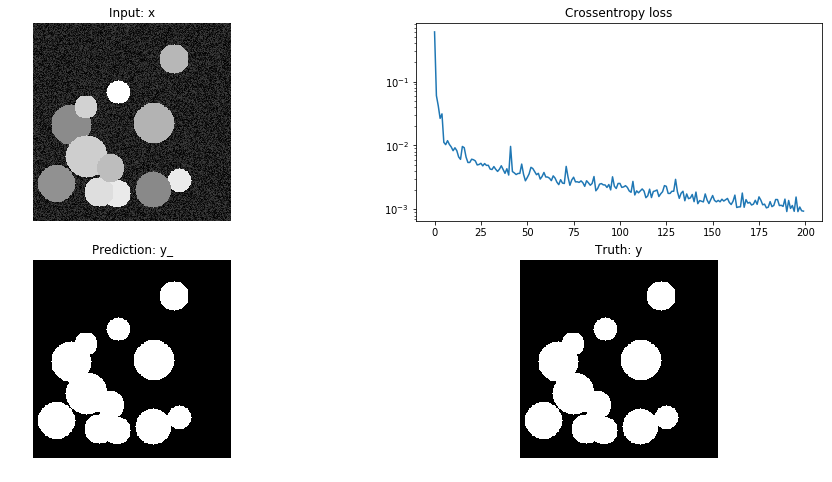

In [6]:
_ = nn.train(input_fn=input_fn, hooks=hooks + [qinit_hook], steps=200)

Similarly, we can [`evaluate`](https://www.tensorflow.org/api_docs/python/tf/estimator/Estimator#evaluate) the model:

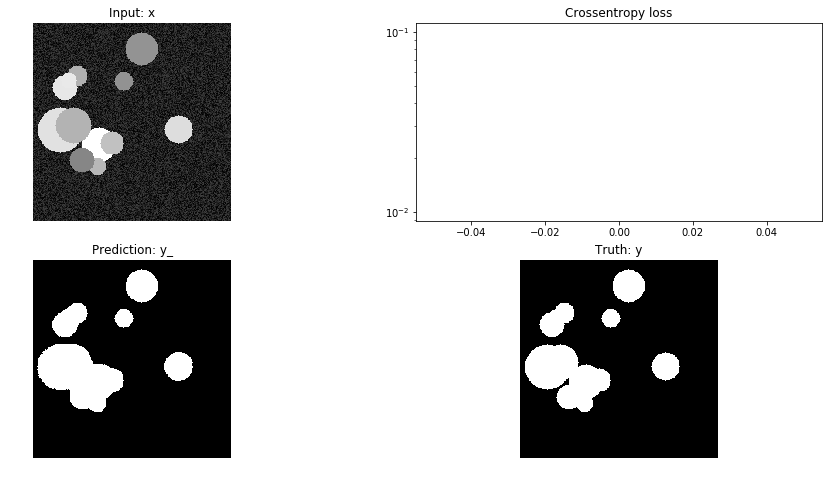

In [7]:
nl_hook.loss = []
eval_input_fn, eval_qinit_hook = reader.get_inputs(file_references=None, 
                                                   mode=tf.estimator.ModeKeys.EVAL,
                                                   example_shapes=reader_example_shapes)

_ = nn.evaluate(input_fn=eval_input_fn, hooks=hooks + [eval_qinit_hook], steps=1)